# Card recognition - mask creation

In this notebook we create masks for symbol and character recognition using the setup images. We apply the same pipeline as we would apply to extract cards. Then we extract the symbol / character from the card and create a binary mask out it.^that will late be use as labelled dataset.

#### For further improvement
Use a contour based metric to improve symbol recognition  
Could use the distance map instead of the center of gravity, because if some part is not detected => shift the center of gravity => shift the entire mask => big loss  

In [2]:
import sys
sys.path.insert(0, '../src/')

import os
import cv2
import pickle
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

from constants import *

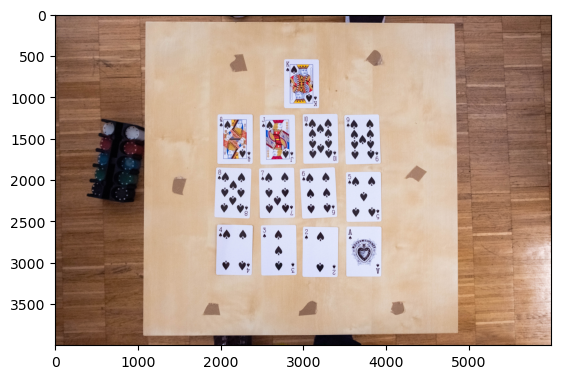

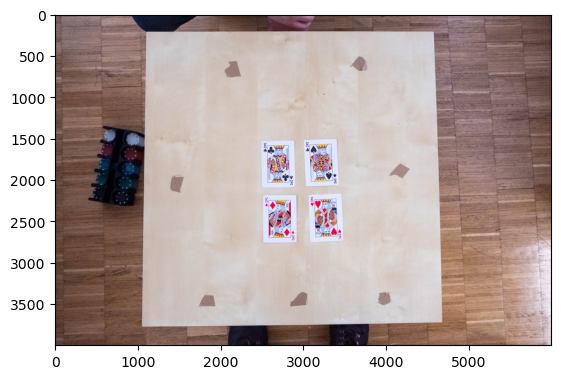

In [3]:
im_spades = Image.open(os.path.join(SETUP_DATA, f"spades_suits.jpg"))
plt.imshow(im_spades)
plt.show()

im_kings = Image.open(os.path.join(SETUP_DATA, f"kings.jpg"))
plt.imshow(im_kings)
plt.show()

# Binary mask pipeline

### Symbols maks creation

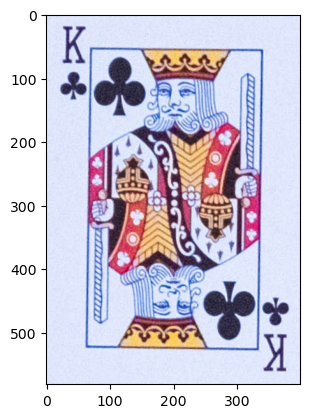

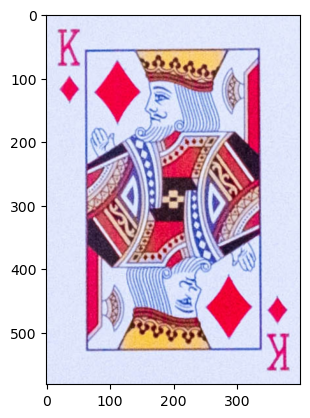

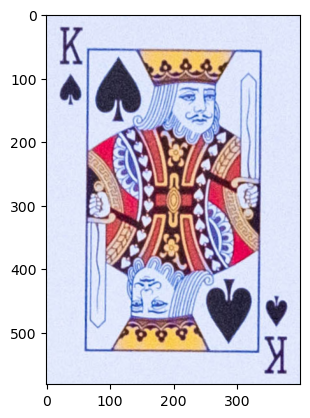

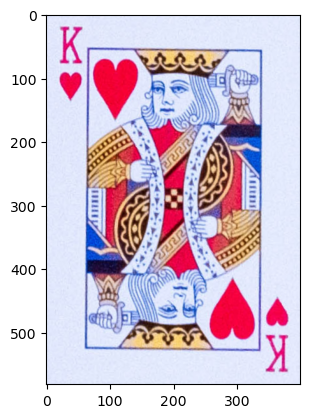

In [4]:
from table_extractor import TableExtractor
from contour_helper import ContourHelper
from card_extractor import CardExtractor

# Extract contour of kings
table_img = TableExtractor.extract_table(np.array(im_kings))
kings_img = table_img[1250:2850, 1250:2700]
kings_contours = ContourHelper.extract_candidate_contours(kings_img, 4, plot = False)[10]
extracted_cards = CardExtractor.extract_cards_from_contours(kings_img, kings_contours, 0.02)
for c in extracted_cards:
    plt.imshow(c)
    plt.show()

In [6]:
def create_centered_mask(cc_labels, target_label, centroids):
  
    h, w = cc_labels.shape
    center_y, center_x = centroids[target_label]
    x, y = (cc_labels == target_label).nonzero()
    centered_x = x - int(center_x) + h
    centered_y = y - int(center_y) + w
    centered_mask = np.zeros((2 * h, 2 * w), dtype=bool)
    centered_mask[(centered_x, centered_y)] = True

    return centered_mask


def extract_symbol_feature(card, card_name="Default_name", plot=False):
    """
    Extract features about symbol/color from an image of a card
    Extracted feature:
         Cropped image of the symbol
         Detected color ('r'-red or 'b'-black)
         A mask of the symbol centered at (25,25)
    Assume:
        The symbol is always at the same place defined by the constant below
        The symbol is the second largest component after the background at that location
        The symbol fits in 50x50
        
    """
    TOP_SYMBOL = 0.13
    BOTTOM_SYMBOL = 0.26
    LEFT_SYMBOL = 0.016
    RIGHT_SYMBOL = 0.17
    
    # Focus on symbol
    h, w, _ = card.shape
    cropped = card[int(TOP_SYMBOL * h):int(BOTTOM_SYMBOL * h), int(LEFT_SYMBOL *  w): int(RIGHT_SYMBOL * w)]
    
    gray = cv2.cvtColor(cropped,cv2.COLOR_BGR2GRAY)
    flag, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_OTSU)
    
    # Extract connected components
    connectivity = 4
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(~thresh, connectivity)
    
    # Find label with the second biggest area (after background)
    symbol_label = np.argsort(stats[:,4])[::-1][1]
    
    # Create a centered mask around (25,25) of the symbol
    centered_mask = create_centered_mask(labels, symbol_label, centroids)
    
    # Mean color in symbol
    mean_color =  cropped[np.where(labels == symbol_label)].mean(axis=(0))
    
    # Determine closest color between red and black
    dist_R = np.abs([255, 0, 0] - mean_color).sum()
    dist_B = mean_color.sum()
    color = 'r' if dist_B > dist_R  else 'b'
    
    if(plot):
        print(f"Symbol extraction pipeline for {card_name}")
        fig, axes = plt.subplots(1, 5, figsize=(7, 30),tight_layout=True)
        axes[0].set_title(f"Cropped")
        axes[0].imshow(cropped)
        axes[1].set_title(f"Threshold")
        axes[1].imshow(thresh)
        axes[2].set_title(f"CC")
        axes[2].imshow(labels)
        
        symbol_img = cropped.copy()
        symbol_img[np.where(labels != symbol_label)] = [255, 255, 255]
        axes[3].set_title(f"Extracted symbol")
        axes[3].imshow(symbol_img)
        axes[4].set_title(f"Centered mask")
        axes[4].imshow(centered_mask)

        plt.show()
        
    
    return (cropped, color, centered_mask)
    
def symbol_classifier_with_mask(color, mask, name_to_mask): 
    if color == "r":
        score_H = (name_to_mask["H"] & mask).sum() / (name_to_mask["H"] | mask).sum()
        score_D = (name_to_mask["D"] & mask).sum() / (name_to_mask["D"] | mask).sum()

        return 'H' if score_H > score_D else 'D'
    elif color == "b":
        score_C = (name_to_mask["C"] & mask).sum() / (name_to_mask["C"] | mask).sum()
        score_S = (name_to_mask["S"] & mask).sum() / (name_to_mask["S"] | mask).sum()
        return 'C' if score_C > score_S else 'S'

Symbol extraction pipeline for img_0


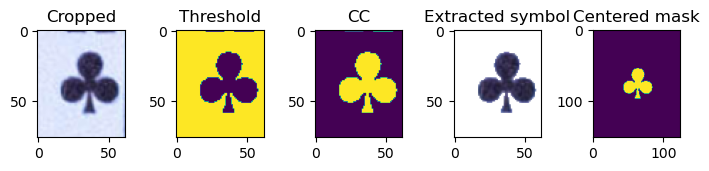

Symbol extraction pipeline for img_1


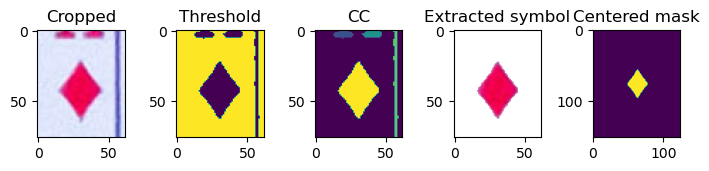

Symbol extraction pipeline for img_2


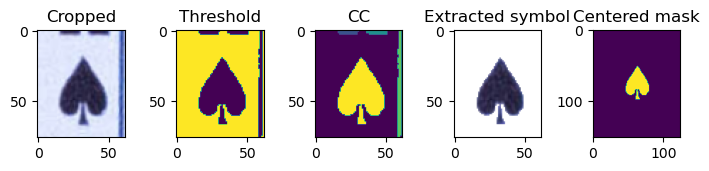

Symbol extraction pipeline for img_3


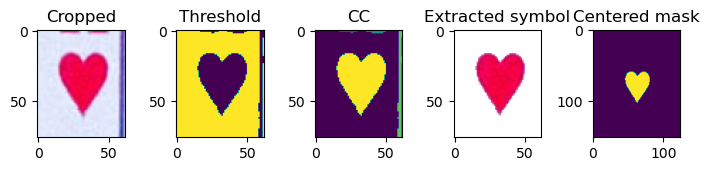

In [7]:

# Create dict for symbol comparaison
train_symbol_features = [extract_symbol_feature(card,f"img_{idx}" ,plot=True) for idx, card in enumerate(extracted_cards)]

masks = [mask for img, color, mask in train_symbol_features]
names = ["C", "D", "S", "H"]

name_to_mask = dict()
for name, mask in zip(names, masks):
    name_to_mask[name] = mask

#with open(PATH_CARD_CLASSIFIER_MASKS + 'symbol_mask_dict.pickle', 'wb') as handle:
#    pickle.dump(name_to_mask, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [8]:
#with open(PATH_SINGLE_CARDS_GROUND_TRUTH +"ground_single_cards_colors", "wb") as fp:   #Pickling
#    pickle.dump(ground_truth_colors, fp)

#with open(PATH_SINGLE_CARDS_GROUND_TRUTH + "ground_single_cards_symbols", "wb") as fp:   #Pickling
#    pickle.dump(groud_truth_symbols, fp)

#with open(PATH_SINGLE_CARDS_GROUND_TRUTH + "ground_single_cards_colors", "rb") as fp:   # Unpickling
#    ground_truth_color = pickle.load(fp)
    
#with open(PATH_SINGLE_CARDS_GROUND_TRUTH + "ground_single_cards_symbols", "rb") as fp:   #Pickling
#    ground_truth_symbol = pickle.load(fp)

def test_color(imgs, colors, ground_truth):
    error_idx = []
    for i in range(len(colors)):
        if(colors[i] != ground_truth[i]):
            error_idx.append(i)
       
    print(f"{len(error_idx)} bad color prediction(s)\n")
    for i in error_idx:
        print(f"Error for img {i}, {colors[i]} instead of {ground_truth[i]}")
        plt.imshow(imgs[i])        
        plt.show()
        
def test_symbols(imgs, symbols, ground_truth):
    error_idx = []
    for i in range(len(symbols)):
        if(symbols[i] != ground_truth[i]):
            error_idx.append(i)
       
    print(f"{len(error_idx)} bad symbols prediction(s)\n")
    for i in error_idx:
        print(f"Error for img {i}, {symbols[i]} instead of {ground_truth[i]}")
        plt.imshow(imgs[i])        
        plt.show()

### Character mask creation

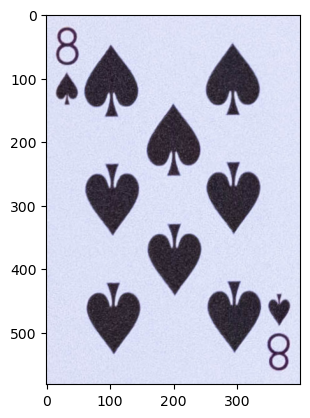

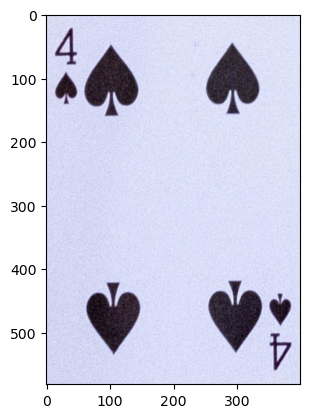

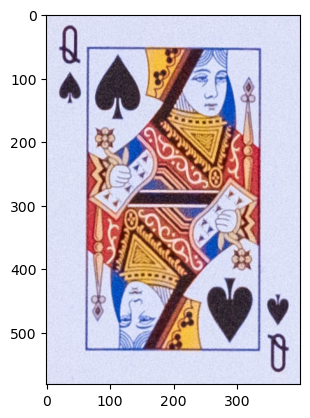

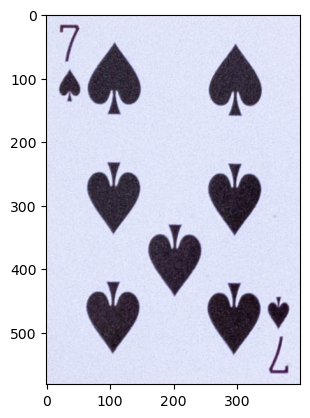

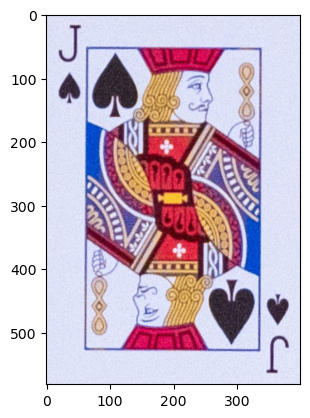

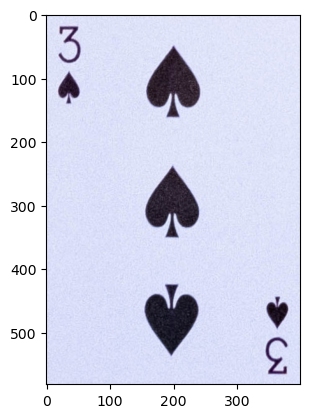

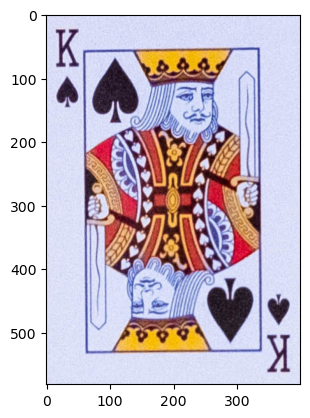

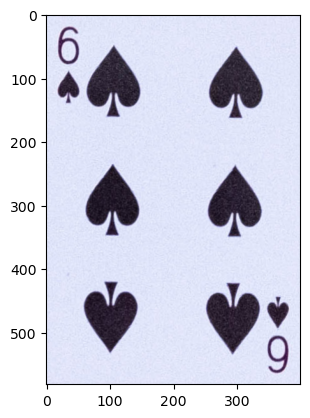

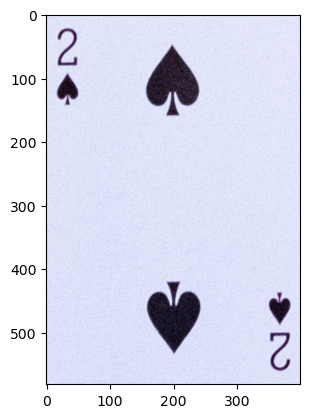

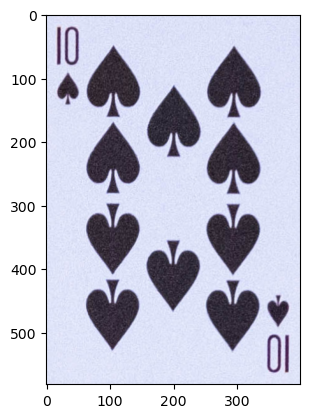

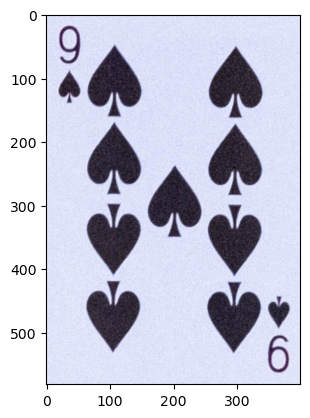

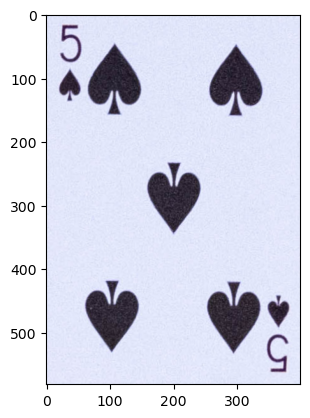

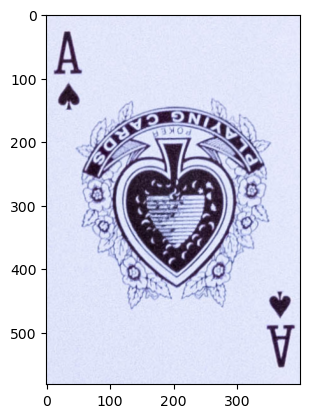

In [9]:
# Extract contour of kings
table_spades = TableExtractor.extract_table(np.array(im_spades))
spades_img = table_spades[400:3200, 700:3000]
spades_contours = ContourHelper.extract_candidate_contours(spades_img, 13, plot = False)[10]
extracted_cards = CardExtractor.extract_cards_from_contours(spades_img, spades_contours, 0.02)
for c in extracted_cards:
    plt.imshow(c)
    plt.show()

In [10]:
def extract_card_character(card, card_name="Default_name", plot=False):
    TOP_CHAR = 0
    BOTTOM_CHAR = 0.16
    LEFT_CHAR = 0.016
    RIGHT_CHAR = 0.18

    # Focus on character
    h, w, _ = card.shape
    cropped = card[int(TOP_CHAR * h):int(BOTTOM_CHAR * h), int(LEFT_CHAR *  w): int(RIGHT_CHAR * w)]
    
    gray = cv2.cvtColor(cropped,cv2.COLOR_BGR2GRAY)
    flag, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_OTSU)
    
    # Extract connected components
    connectivity = 4
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(~thresh, connectivity)
    
    # Find label with the second biggest area (after background)
    char_label = np.argsort(stats[:,4])[::-1][1]
        
    centered_mask = create_centered_mask(labels, char_label, centroids)
    
    if(plot):
        print(f"Character extraction pipeline for {card_name}")
        fig, axes = plt.subplots(1, 4, figsize=(7, 30),tight_layout=True)
        axes[0].set_title(f"Cropped")
        axes[0].imshow(cropped)
        axes[1].set_title(f"Threshold")
        axes[1].imshow(thresh)
        axes[2].set_title(f"CC")
        axes[2].imshow(labels)
        axes[3].set_title(f"Centered mask")
        axes[3].imshow(centered_mask)

        plt.show()
    
    return (cropped, centered_mask)

Character extraction pipeline for Default_name


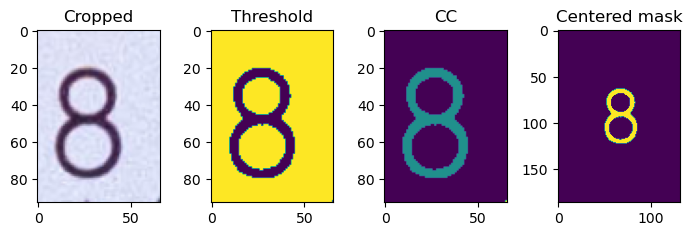

Character extraction pipeline for Default_name


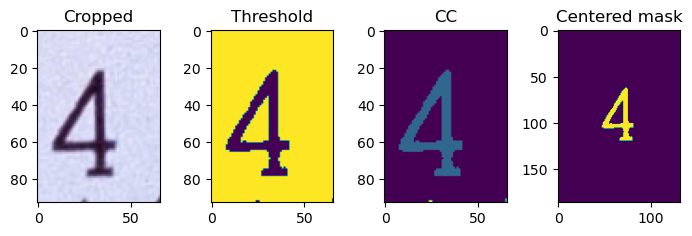

Character extraction pipeline for Default_name


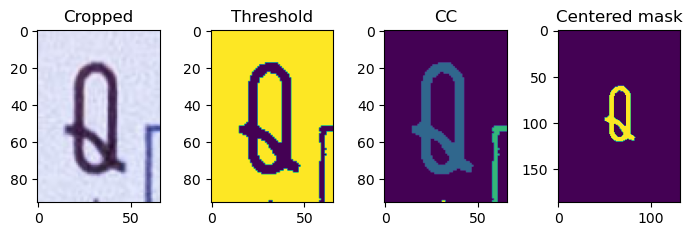

Character extraction pipeline for Default_name


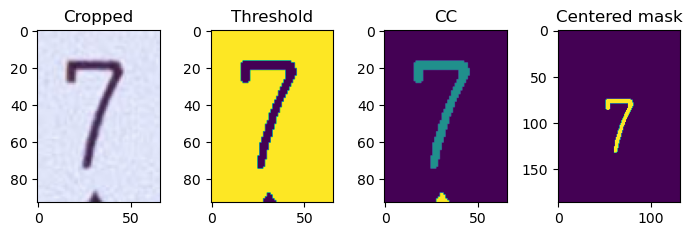

Character extraction pipeline for Default_name


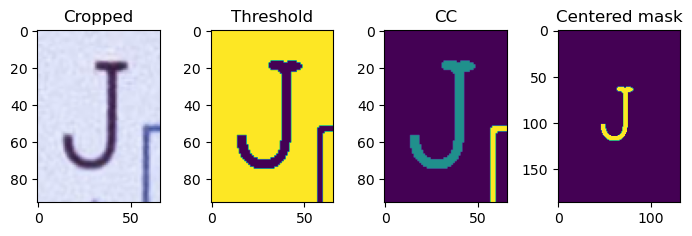

Character extraction pipeline for Default_name


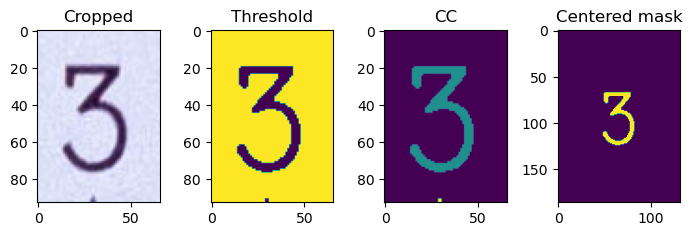

Character extraction pipeline for Default_name


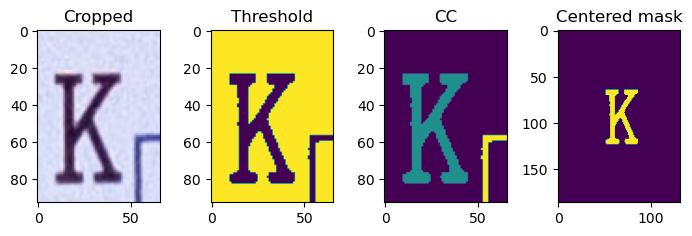

Character extraction pipeline for Default_name


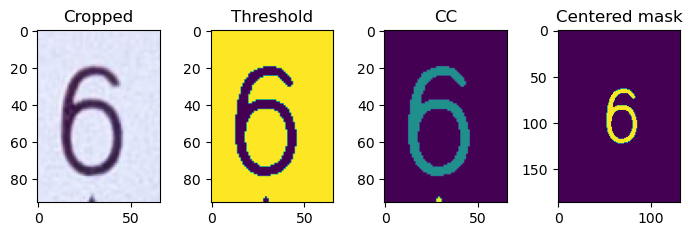

Character extraction pipeline for Default_name


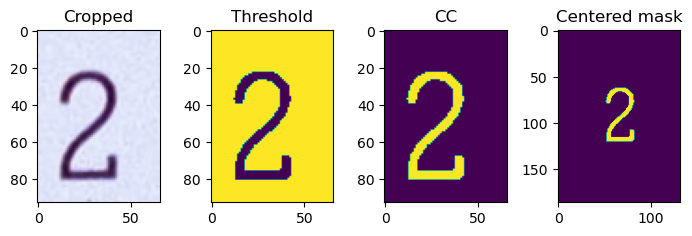

Character extraction pipeline for Default_name


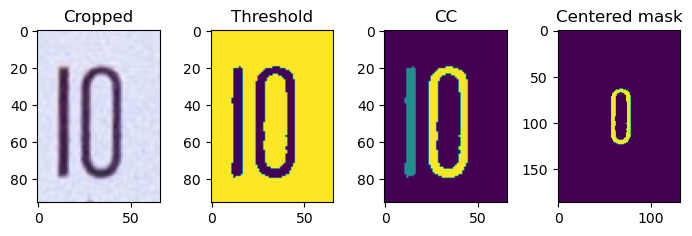

Character extraction pipeline for Default_name


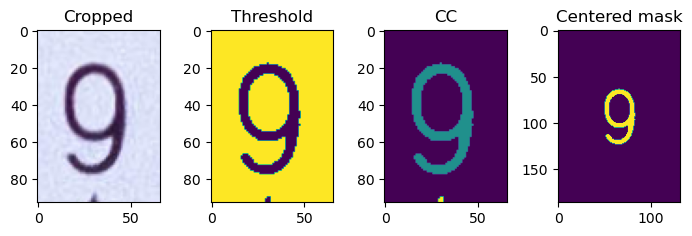

Character extraction pipeline for Default_name


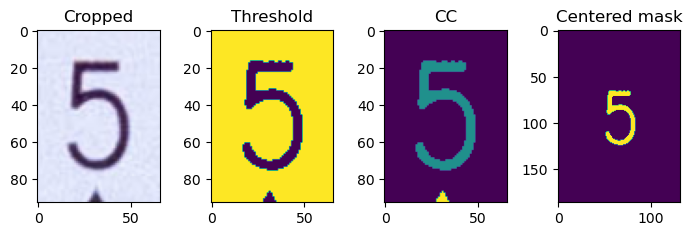

Character extraction pipeline for Default_name


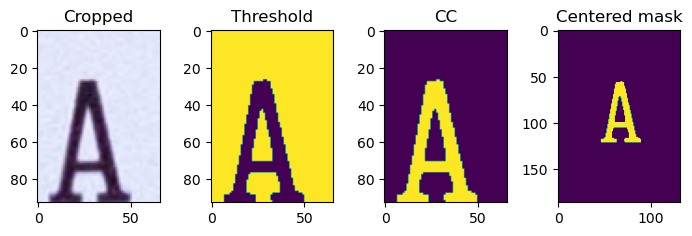

In [12]:
train_symbol_features = [extract_card_character(card, plot=True) for card in extracted_cards]

In [13]:
masks_labels = ["8", "4", "Q", "7", "J", "3","K", "6","2","10","9", "5", "A"]
char_masks = [mask for crop, mask in train_symbol_features]

char_to_mask = dict()
for name, mask in zip(masks_labels, char_masks):
    char_to_mask[name] = mask

with open(PATH_CARD_CLASSIFIER_MASKS +'char_mask_dict.pickle', 'wb') as handle:
    pickle.dump(char_to_mask, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
with open(PATH_CARD_CLASSIFIER_MASKS + 'char_mask_dict.pickle', 'rb') as handle:
    char_to_mask = pickle.load(handle)
    for name, mask in char_to_mask.items():
        char_to_mask[name]= mask.astype(bool)
    
def char_classifier_with_mask(mask, char_to_mask = char_to_mask): 
    best_score = -1
    best_label = None
    for label, label_mask in char_to_mask.items():
        score = (mask & label_mask).sum() / (mask | label_mask).sum()
        if (score > best_score):
            best_score = score
            best_label = label
    return best_label

In [15]:
#with open(PATH_SINGLE_CARDS_GROUND_TRUTH + "ground_single_cards_char", "wb") as fp:   #Pickling
#    pickle.dump(ground_truth_char, fp)

#with open(PATH_SINGLE_CARDS_GROUND_TRUTH + "ground_single_cards_char", "rb") as fp:   #Pickling
#    ground_truth_char = pickle.load(fp)

def test_char(imgs, chars, ground_truth):
    error_idx = []
    for i in range(len(chars)):
        if(chars[i] != ground_truth[i]):
            error_idx.append(i)
       
    print(f"{len(error_idx)} bad char prediction(s)\n")
    for i in error_idx:
        print(f"Error for img {i}, {chars[i]} instead of {ground_truth[i]}")
        plt.imshow(imgs[i])        
        plt.show()

### Discussion
In char 10 only the 0 is taken into account since we are keeping only one principal component